In [1]:
#Will fix this when finalized
!pip install git+https://github.com/vdlad/cleanlab.git

  Cloning https://github.com/vdlad/cleanlab.git to /tmp/pip-req-build-nf185j6m
  Running command git clone --filter=blob:none --quiet https://github.com/vdlad/cleanlab.git /tmp/pip-req-build-nf185j6m
  Resolved https://github.com/vdlad/cleanlab.git to commit ceaefe25593b793fb5d4c62453ca23263b3bea24
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# Find Label Errors in Semantic Segmentation Datasets

This 5-minute quickstart tutorial shows how you can use cleanlab to find potential label errors in image datasets  for semantic segmentation. In semantic segmenation for supervised learning settings, our data consists of a series of images and a corresponding mask which which labels the image pixel-wise, one of K classes. Oftentimes, these can also be one-hot encoded, which can easily be converted to the class integer-encoding we use here . Models are trained to predict the class of each pixel in a photograph, however the labeled mask may contain errors. There are numerous important examples for semantic segmentation such as datasets for self-driving cars and medical imaging, therefore it is important to maintain high quality labels. In order to to test our error finding methods we utilize the SYNTHIA dataset, a synthetic semantic segmentations dataset in which we introduce errors.

We introduce class drops in our SYNTHIA dataset, which are representative of real life scenarios:

- Drop - The annotation does not label a class on the photograph. Same as being swapped with the ``unlabeled`` class.



**Overview of what we'll do in this tutorial:** 
 
- Rank images based on their overall label quality using `cleanlab.semantic_segmentation.rank.get_label_quality_scores`.
- Test out 2 methods to determine score and see how they perform
- Perform a more in-depth analysis using 
`cleanlab.semantic_segmentation.filter.find_label_issues`.
- Visualize our errors using 
`cleanlab.semantic_segmentation.summary.display_issues`.
and 
`cleanlab.semantic_segmentation.summary.common_label_issues`.


<div class="alert alert-info">
Quickstart
<br/>
    
cleanlab uses two inputs to handle semantic segmentation data classification data:
- `labels`: Array of dimension (N,H,W) where N is the number of images, K is the number of classes, and H and W are dimension of the image. We assume an integer encoded image. For one-hot encoding one can `np.argmax(labels_one_hot,axis=1)` assuming that `labels_one_hot` is of dimension (N,K,H,W)
- `pred_probs`: Array of dimension (N,K,H,W), similar to `labels` where `K` is the number of classes.

Using these, you can find/display label issues with this code: 

<div  class=markdown markdown="1" style="background:white;margin:16px">  
    
```python

from cleanlab.semantic_segmentation.filter import find_label_issues 
from cleanlab.semantic_segmentation.summary import display_issues
    
issues = find_label_issues(labels, pred_probs)
display_issues(issues, pred_probs=pred_probs, labels=labels,
               top=10)

```
    
</div>
</div>

## 1. Install required dependencies and download data

You can use `pip` to install all packages required for this tutorial as follows: 

    !pip install cleanlab 

In [2]:
!wget -nc 'https://cleanlab-public.s3.amazonaws.com/ImageSegmentation/given_masks.npy' 

File ‘given_masks.npy’ already there; not retrieving.



In [3]:
!wget -nc 'https://cleanlab-public.s3.amazonaws.com/ImageSegmentation/predicted_masks.npy' 

File ‘predicted_masks.npy’ already there; not retrieving.



In [4]:
# Package installation (hidden on docs website).

dependencies = ["cleanlab"]

if "google.colab" in str(get_ipython()):  # Check if it's running in Google Colab
    %pip install cleanlab  # for colab
    cmd = ' '.join([dep for dep in dependencies if dep != "cleanlab"])
    %pip install $cmd
else:
    missing_dependencies = []
    for dependency in dependencies:
        try:
            __import__(dependency)
        except ImportError:
            missing_dependencies.append(dependency)

    if len(missing_dependencies) > 0:
        print("Missing required dependencies:")
        print(*missing_dependencies, sep=", ")
        print("\nPlease install them before running the rest of this notebook.")

In [5]:
import numpy as np
import cleanlab

#*FIXME*
from cleanlab.segmentation.filter import find_label_issues 
from cleanlab.segmentation.rank import get_label_quality_scores, issues_from_scores 
from cleanlab.segmentation.summary import display_issues, common_label_issues, filter_by_class 

# np.set_printoptions(suppress=True)

## 2. Get data, labels, and pred_probs

In semantic segmentation tasks, each pixel in the dataset is labeled with one of *K* possible classes.
To find label issues and obtain the label quality score for each image cleanlab requires predicted class probabilities from a trained classifier. These `pred_probs` contain a length-*K* vector for **each** pixel in the dataset (which sums to 1 for each pixel). This results in an array of size `(N,K,H,W)`  Here we use `pred_probs` which are from the SYNTHIA dataset. Our example notebook ["INSERT NOTEBOOK NAME HERE"](INSET LINK HERE) *FIXME* contains the code to produce such `pred_probs` and save them in a `.npy` file, which we simply load here via a `read_npy` function (can skip these details).

### labels
#### dim: (N,H,W)

In [6]:
label_filepaths ='given_masks.npy'
labels = np.load(label_filepaths, mmap_mode='r+')
labels.shape

(139, 1088, 1920)

### pred_probs
#### dim: (N,K,H,W)

In [7]:
pred_probs_filepaths ='predicted_masks.npy'
pred_probs = np.load(pred_probs_filepaths, mmap_mode='r+')
pred_probs.shape

(139, 20, 1088, 1920)

Note that these correspond to the labeled mask from the dataset, and the extracted probabilities of a trained classifier. If using your own dataset, which may consider iterating on memmaped numpy arrays.

- `labels`: Array of dimension (N,H,W) where N is the number of images, K is the number of classes, and H and W are dimension of the image. We assume an integer encoded image. For one-hot encoding one can `np.argmax(labels_one_hot,axis=1)` assuming that `labels_one_hot` is of dimension (N,K,H,W)
- `pred_probs`: Array of dimension (N,K,H,W), similar to `labels` where `K` is the number of classes.

## 3. Use cleanlab to find label issues 

Based on the given labels and out-of-sample predicted probabilities, cleanlab can quickly help us identify label issues in our dataset. Here we request that the indices of the identified label issues be sorted by cleanlab’s self-confidence score, which measures the quality of each given label via the probability assigned to it in our model’s prediction. The returned `issues` is a boolean mask of dimension `(N,H,W)`, where `True` corresponds to a detected error. They are returned sorted by the `label_quality_score`, with the lowest score coming first. 

In [8]:
issues = find_label_issues(labels, pred_probs,downsample = 16, n_jobs=None, batch_size=100000)

number of examples processed for estimating thresholds:   0%|          | 0/1134240 [00:00<?, ?it/s]

number of examples processed for checking labels:   0%|          | 0/1134240 [00:00<?, ?it/s]

Total number of examples whose labels have been evaluated: 1134240


Key notes:

 - The ``downsample`` flag gives us performance benefits for large datasets, but for maximum accuracy we can keep the value lower.

 - To maximize efficiency, try to use the largest `batch_size` your memory allows.

Let's look at the top 2 issues that cleanlab thinks are most likely mislabeled. 

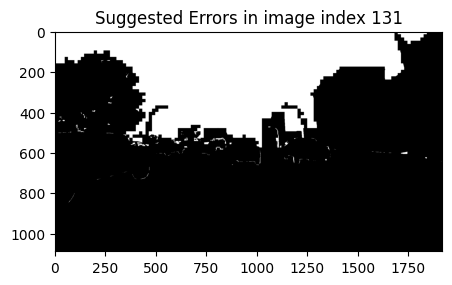

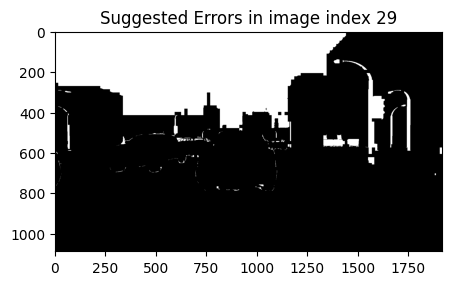

In [9]:
display_issues(issues,top=2)

To take a closer look we can include the ``labels`` and ``pred_probs`` to compare!

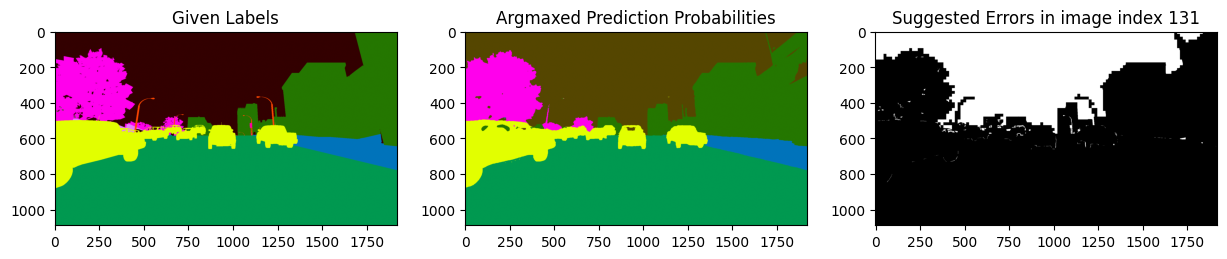

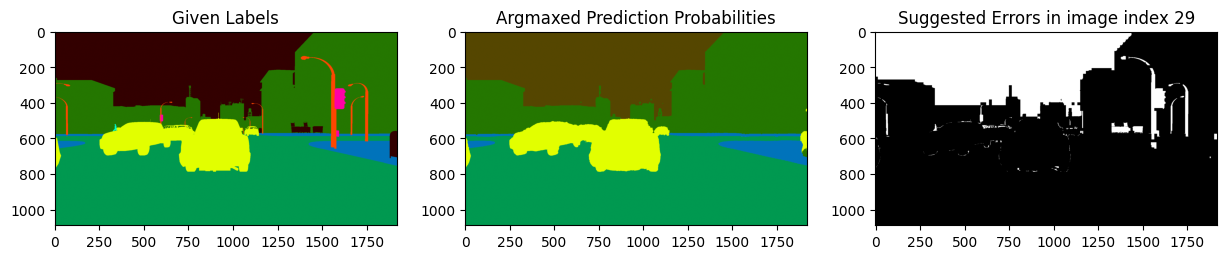

In [10]:
display_issues(issues, labels=labels, pred_probs=pred_probs, top=2)

Looks like the sky was mislabeled as clearly seen in comparing the plots on the output

### Most common class-level image mislabels 

We may also wish to understand which classes tend to be most commonly mislabeled throughout the entire dataset:

In [11]:
SYNTHIA_CLASSES = ['unlabeled','sky', 'building', 'road', 'sidewalk', 'fence', 'vegetation','pole','car', \
               'traffic sign','person','bicycle','motorcycle','traffic light', 'terrain', \
               'rider',  'truck', 'bus', 'train','wall']
common_label_issues(issues,labels=labels, pred_probs=pred_probs, class_names=SYNTHIA_CLASSES)

100%|██████████| 10616151/10616151 [01:04<00:00, 164660.11it/s]

Class 'unlabeled' is potentially mislabeled as class 'sky' 3764912 times throughout the dataset
Class 'unlabeled' is potentially mislabeled as class 'car' 1691561 times throughout the dataset
Class 'pole' is potentially mislabeled as class 'building' 1567818 times throughout the dataset
Class 'unlabeled' is potentially mislabeled as class 'building' 1224682 times throughout the dataset
Class 'wall' is potentially mislabeled as class 'building' 315644 times throughout the dataset
Class 'person' is potentially mislabeled as class 'building' 293412 times throughout the dataset
Class 'unlabeled' is potentially mislabeled as class 'sidewalk' 263385 times throughout the dataset
Class 'pole' is potentially mislabeled as class 'sidewalk' 230966 times throughout the dataset
Class 'traffic light' is potentially mislabeled as class 'building' 215248 times throughout the dataset
Class 'wall' is potentially mislabeled as class 'sidewalk' 191852 times throughout the dataset
Class 'building' is poten

,given_label,predicted_label,num_label_issues
0,unlabeled,sky,3764912
1,unlabeled,car,1691561
2,pole,building,1567818
3,unlabeled,building,1224682
4,wall,building,315644
5,person,building,293412
6,unlabeled,sidewalk,263385
7,pole,sidewalk,230966
8,traffic light,building,215248
9,wall,sidewalk,191852


The printed information above is also stored in pd.DataFrame 

### Find errors in images by focusing on just one class


In [12]:
class_issues = filter_by_class(SYNTHIA_CLASSES.index("car"), issues,labels=labels, pred_probs=pred_probs)

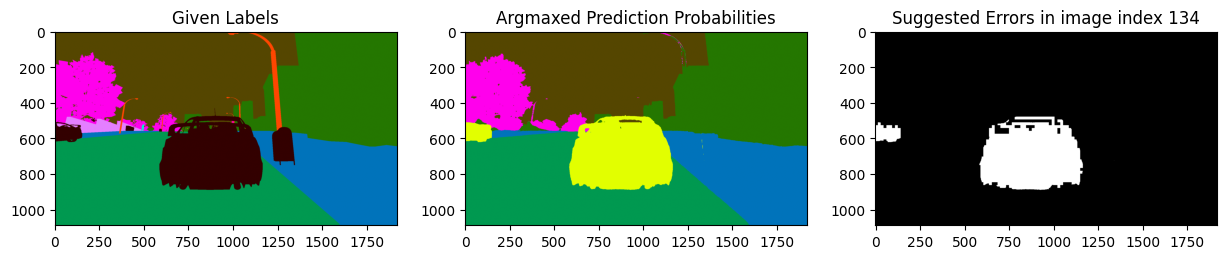

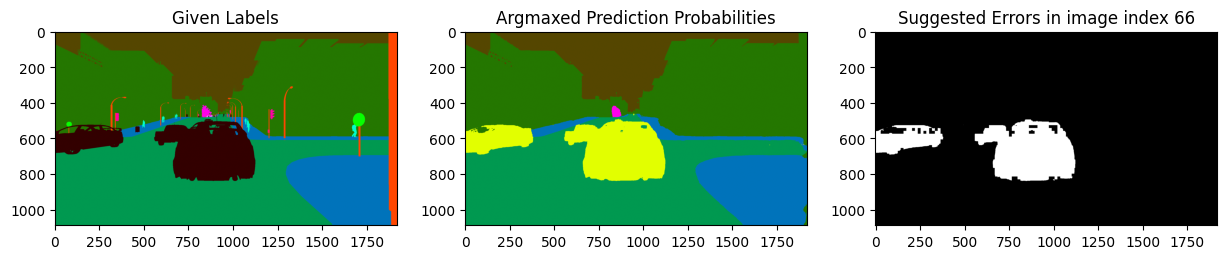

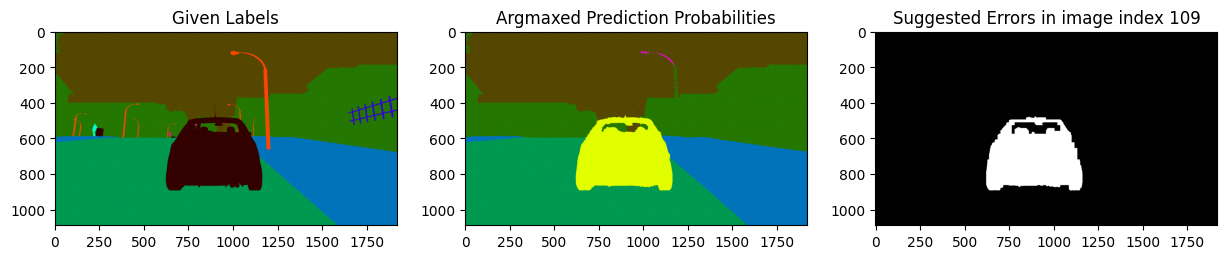

In [13]:
display_issues(class_issues, pred_probs=pred_probs, labels=labels, top=3)

###  Image label quality score 

For best reviewing label issues in a semantic segmentation dataset, you want to look at images one at a time. Here images more likely to contain a label error should be ranked earlier. Cleanlab can provide an overall label quality score for each image (ranging from 0 to 1) such that lower scores indicate images more likely to contain some mislabeled class. We can also obtain label quality scores for each individual image and manually decide which of these are label issues by thresholding them. For automatically estimating which pixels are mislabeled (and the number of label errors), you should use `find_label_issues()` instead. `get_label_quality_scores()` is useful if you only have time to review a few images and want to prioritize which, or if you're specifically aiming to detect label errors with high precision (or high recall) rather than overall estimation of the set of mislabeled tokens.

The default method for calculating is using a ``softmin``.

In [14]:
image_scores_softmin, pixel_scores = get_label_quality_scores(labels, pred_probs, method="softmin")

images processed using softmin:   0%|          | 0/139 [00:00<?, ?it/s]

The secondary method uses the same principles as confident learning from ``find_label_issues`` to determine a score.

In [15]:
image_scores_num_issues, pixel_scores = get_label_quality_scores(labels, pred_probs,  method="num_pixel_issues", downsample = 16, n_jobs=None, batch_size=100000)

number of examples processed for estimating thresholds:   0%|          | 0/1134240 [00:00<?, ?it/s]

number of examples processed for checking labels:   0%|          | 0/1134240 [00:00<?, ?it/s]

Total number of examples whose labels have been evaluated: 1134240


Both methods above return the ``pixel_scores``, which is a 0 to 1 score for each pixel. We can use the following function to extract the same style `True` or `False` mask as `find_label_issues()`.

In [17]:
issues_from_score = issues_from_scores(image_scores_softmin, pixel_scores, threshold=0.5) 

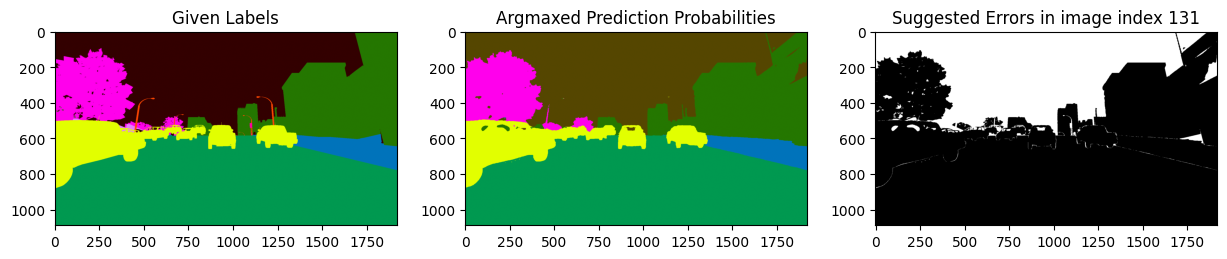

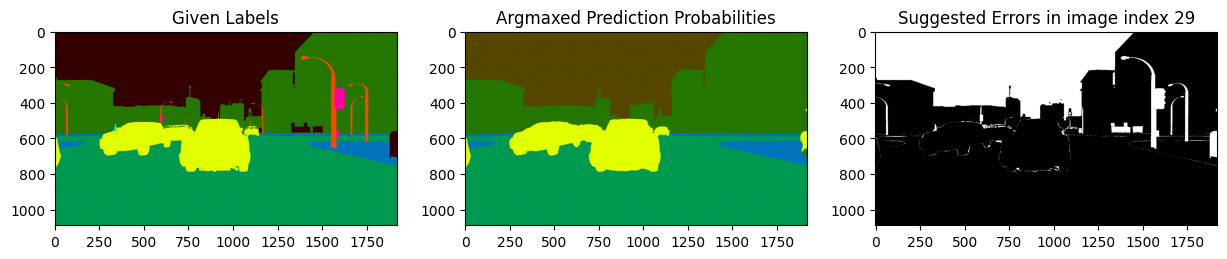

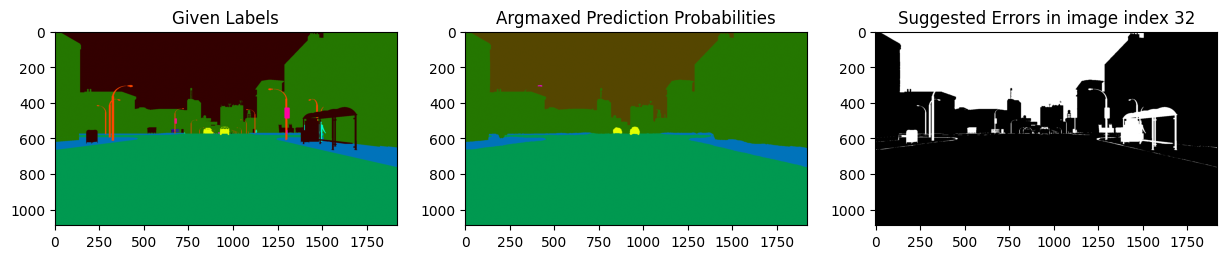

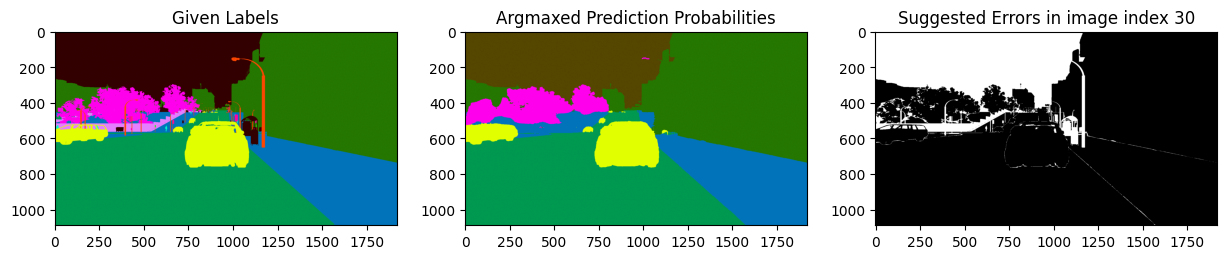

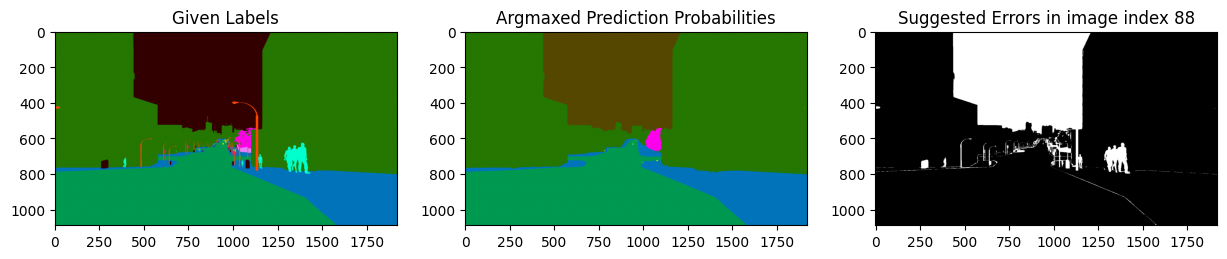

In [18]:
display_issues(issues_from_score, pred_probs=pred_probs, labels=labels, top=5) 

We can see that the errors are dominated by label errors in the sky!